# Intro & Motivation

We are ultimately motivated by the need for outlier detection and removal in [Chainlink price contracts](https://feeds.chain.link/). Because outlier removal is so context-dependent — frequently, statisticians use visual means and domain-knowledge to remove outliers with confidence — the initial part of this report/analysis focuses on understanding the data as-is; in particular, we focus on whether or not Assumption of Normality holds and on understanding how and why the data varies "naturally".

The later part of the report \[*not complete*\] covers outlier removal techniques, focussing on those that are most appropriate for this particular context. With outlier removal, our goal is twofold:

* remove values to improve the final aggregation, and
* identify poor performing and malicious oracles.

Note: unlike in many statistical contexts, here, critically, we have to consider potential attack vectors for each proposed approach (for both aggregation and outlier detection). The number of unique attack vectors in this context is strictly greater than in traditional consensus systems because, here, we have continuous, real-valued data and not simply discrete values that we take for granted in more traditional consensus models. One can imagine a potential attacker abusing the "fog of randomness" — the expectation of a certain amount of error, randomness, and variation with real-valued samples — in order to attack the system, i.e. skew the aggregate result.

I'd like to emphasize that, as far as I can tell, this is a very novel area of research (mitigating attacks by adversaries on data aggregation systems with continuous, real-valued quantities). The closest research areas that I can think of, that remotely resemble this, are: adversarial attacks on neural networks and differential privacy. (If you're familiar with any other areas of research that resemble this kind of problem-solving, please let me know!)

# Table of contents

A general study of the data with some comments on outlier removal at the end.

* Part 1. [Getting the data](#Part1)
* Part 2. [Analyzing the data](#Part2)

    * 1. [Distribution of responses](#1)
        * 1.1. [Informal comparison to Gaussian](#1.1)
    * 2. [Investigating variance in responses](#2)
        * 2.1. [A visual study](#2.1)
        * 2.2. [Exploring causes of variance](#2.2)
            * 2.2.1 [Price volatility, round duration, and dispersion of response times](#2.2.1)
            * 2.2.2 [Multivariate regression](#2.2.2)
            * 2.2.3 [How much do individual oracles have an effect on variability?](#2.2.3)
        * 2.3 [Relationship between response time and accuracy of response](#2.3)

* Part 3. [Conclusion & Discussion, so far](#Part3)

# Part 1: Getting the data <a class="anchor" id="Part1"></a>
Note: we focus our analysis on the ETH-USD price contract.

In [1]:
import numpy as np
import pandas as pd
# suppresses annoying SettingWithCopyWarning
pd.options.mode.chained_assignment = None
import quantumrandom
import random
import statsmodels.api as sm
import time
from collections import defaultdict
from datetime import datetime, timedelta
from scipy import stats
from tqdm.notebook import tqdm
# disable locks due to random deadlocks
tqdm.get_lock().locks = []
from web3 import Web3

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, DivergingNorm, LinearSegmentedColormap
COLORS_10 = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3',
             '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd']
PALLETTE_10 = sns.set_palette(sns.color_palette(COLORS_10))
CHAINLINK_BLUE = '#2b5cdc'
CHAINLINK_BLUE_LIGHT = '#698CE5'
GREEN = '#69e584'
RED = '#dc2b5c'

from utils import (
    connect,
    load_oracle_responses,
    load_price_data,
    load_round_metrics,
    generate_random_gaussians,
)

convert_unixtime = lambda ts: datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

/Users/sasa/chainlink-price-contract-analysis/utils.py:41: UserWarning: CryptoCompare API key is missing. Go here to set up an account: https://min-api.cryptocompare.com/pricing
  warnings.warn("CryptoCompare API key is missing. Go here to set up an account: https://min-api.cryptocompare.com/pricing")


The data gathering/loading functions are in `utils.py`. The functions grew to be quite long, so I migrated them over to a seperate file.

In [69]:
### oracle responses ###
df_responses = load_oracle_responses()

Latest round: 1019
Last saved round: 994.
First block: 2020-05-09 05:19:11.
Round 995 USD-ETH price response: 2020-05-09 06:01:38.
Querying blockchain in chunks of 500 blocks. 12 chunks total.



Done.
Augmenting entries...
Adding timestamps...


Done.


In [70]:
df_responses

,price,answer_id,oracle,blockNumber,timestamp,date,price_float
0,16631351520,1,0x0Ce0224ba488ffC0F46bE32b333a874Eb775c613,9288039,1579122628,2020-01-15 21:10:28,166.313515
1,16638000000,1,0xB92ec7D213a28e21b426D79EDe3c9BBcf6917c09,9288039,1579122628,2020-01-15 21:10:28,166.380000
2,16652082250,1,0x8c85a06EB3854Df0d502B2b00169DBfB8B603Bf3,9288038,1579122590,2020-01-15 21:09:50,166.520823
3,16604933280,1,0x89f70fA9F439dbd0A1BC22a09BEFc56adA04d9b4,9288038,1579122590,2020-01-15 21:09:50,166.049333
4,16563811450,1,0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a,9288038,1579122590,2020-01-15 21:09:50,165.638115
...,...,...,...,...,...,...,...
21359,18781000000,1019,0x58c69aFF4Df980357034eA98AaD35bbF78cBD849,10035765,1589077651,2020-05-10 02:27:31,187.810000
21360,18781000000,1019,0x64FE692be4b42F4Ac9d4617aB824E088350C11C2,10035765,1589077651,2020-05-10 02:27:31,187.810000
21361,18798895644,1019,0x7A9d706B2A3b54f7Cf3b5F2FcF94c5e2B3d7b24B,10035765,1589077651,2020-05-10 02:27:31,187.988956
21362,18870000000,1019,0x83dA1beEb89Ffaf56d0B7C50aFB0A66Fb4DF8cB1,10035765,1589077651,2020-05-10 02:27:31,188.700000


In [4]:
# remove all negatives
# I think this is a result of unfinished rounds
# same with extremely large values
df_responses = df_responses[df_responses["price_float"] >= 0]
df_responses = df_responses[df_responses["price_float"] < 1e8]

# Part 2: Analyzing the data <a class="anchor" id="Part2"></a>

## 1. Distribution of price responses per heartbeat, for a recent 24 hour period <a class="anchor" id="1"></a>

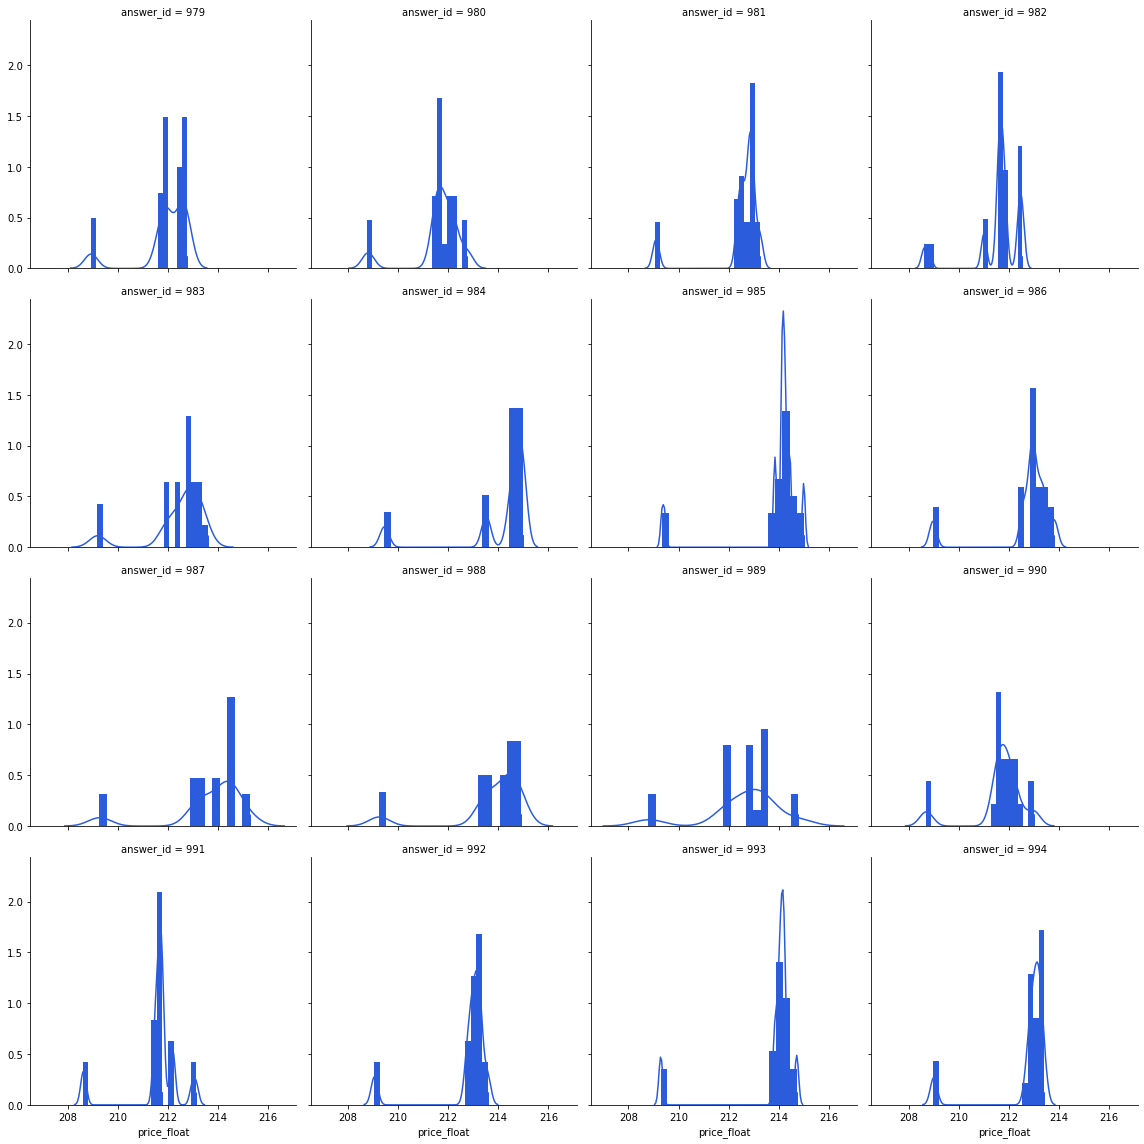

In [5]:
HOURS = 24

# get last 16
lastn = 16
last_ans_id = max(df_responses['answer_id'])
df = df_responses[df_responses['answer_id'] > last_ans_id - lastn]

g = sns.FacetGrid(df, col="answer_id", col_wrap=4, height=4, aspect=1)
g.map(sns.distplot, "price_float", rug=True, hist_kws=dict(alpha=1), **{'bins': 20, 'color': CHAINLINK_BLUE});

Normalized (mean=0, std=1):

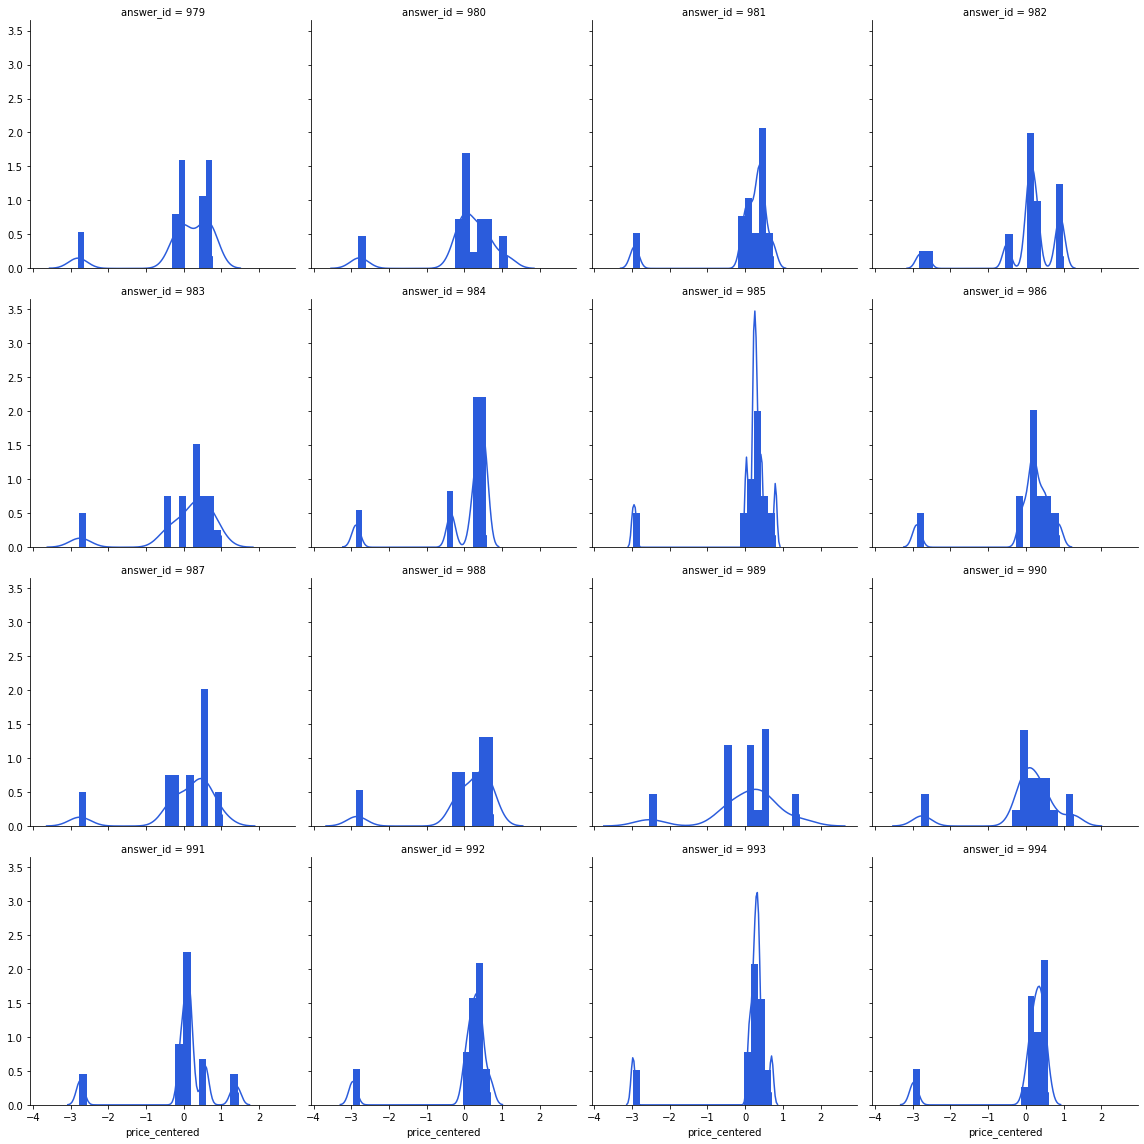

In [7]:
df.loc[:,'price_centered'] = df_responses.groupby('answer_id')['price_float'].transform(
    lambda x: (x - x.mean()) / x.std()
) 
g = sns.FacetGrid(df, col="answer_id", col_wrap=4, height=4, aspect=1)
g.map(sns.distplot, "price_centered", rug=True, hist_kws=dict(alpha=1), **{'bins': 20, 'color': CHAINLINK_BLUE});

### Observations & Thoughts:
* We can't assume, based on these distributions, that we are always dealing with *normally distributed data*; that is, we should be careful about assuming normality.
    * This is perhaps due to the fact that we have only ~20 responses. Fitting distributions to small data sets is always a problem. But perhaps there's something else going on here ...
* Often we'll see what appears to be a **multi/bi-modal distribution**.
    * Could this be a result of prices being reported from different exchanges? i.e. some nodes aren't aggregating reponses, instead they report from one or two sources? Where do oracles get their data from?
        * I could test this hypothesis if I knew where the oracles were getting their data from.
        * **Idea**: Oracles that aggregate their responses from multiple exchanges are likely to have responses closer to the mean/median. Would penalizing oracles with responses further from the center of the distribution incentivize them to gather information from many sources (which is what we want)?
        * **Idea**: a weighted average of prices from exchanges, where the weight is a function(\*) of *trading volume* is a better aggregation method for price oracles than simple average. This is because prices reported from various exchanges, weighted by the trading volume of those exchanges, is clearly closer to what we envision as the "true price".
            * Note: in the case that oracles *are* reporting prices weighted by trading volume, then a simple mean/median is fine.
    * Could this be due to oracles reporting at different times within a round?
        * **This will be tested in a bit.**

(\*) I say *function of* trading volume, because the weighting should be proportional to trading volume, but not exactly equal to it due to interactions such as liquidity (e.g. trading volume is directly correlated with liquidity which has an effect on price).

## 1.1 Informal comparison to Gaussian<a class="anchor" id="1.1"></a>
One might assume that the irregularities with the above distributions is simply an artifact arising from a small sample ($n=21$, see table below). We can informally test this by plotting samples ($n=21$) from a *true* normal distribution and then do an informal, visually comparison to our plots above.

In [8]:
df = df_responses[['answer_id']].groupby(['answer_id']).agg(
    count_col=pd.NamedAgg(
        column="answer_id",
        aggfunc="count")
)
df.rename(columns={'count_col': 'n_oracles'}, inplace=True)

df.groupby(['n_oracles']).agg(
    count_col=pd.NamedAgg(
        column="n_oracles",
        aggfunc="count")
).rename(columns={'count_col': 'count'})

,count
n_oracles,
17,1
18,1
19,4
20,111
21,859
22,5
23,2
24,3
27,1


The large majority of the time we have 21 oracles responding.

Drawing 16 random samples (n=21) from Gaussian


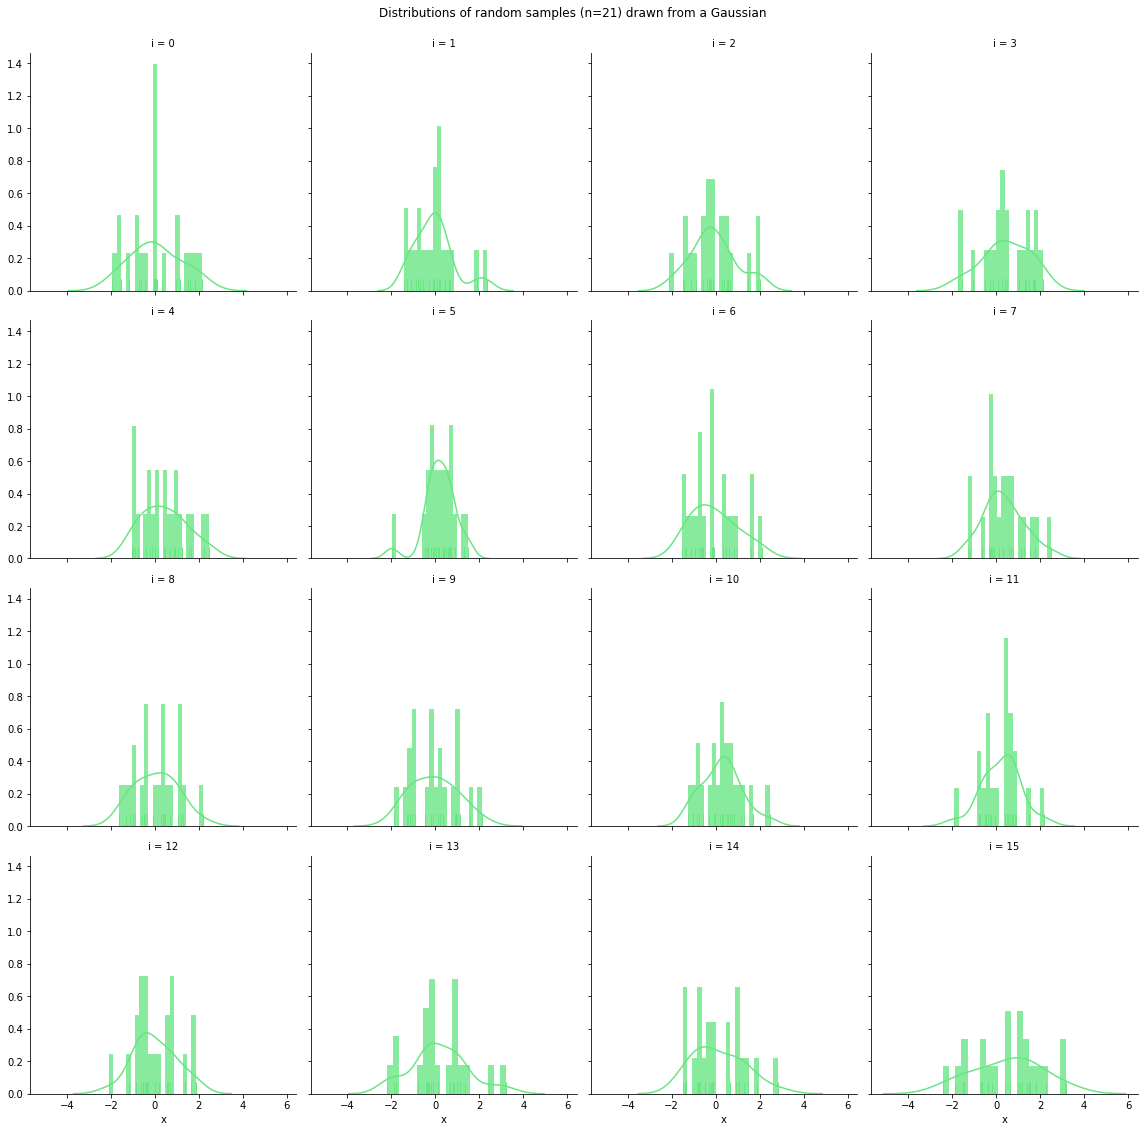

In [9]:
N_SAMPLES = 16
df = generate_random_gaussians(21, N_SAMPLES)
g = sns.FacetGrid(df, col="i", col_wrap=4, height=4, aspect=1)
g.map(sns.distplot, "x", rug=True, hist_kws=dict(alpha=0.8), **{'bins': 20, 'color': GREEN});
g.fig.suptitle('Distributions of random samples (n=21) drawn from a Gaussian')
# add space below title
g.fig.subplots_adjust(top=0.94)

### Observations & Thoughts:
- We note, visually, that bimodal \& multimodal distributions are not that common in samples ($n = 21$) generated from true normal distributions, suggesting that there is some underlying factor for why our oracle response distributions are multimodal.

### Further comparison to Gaussian: Violin plots

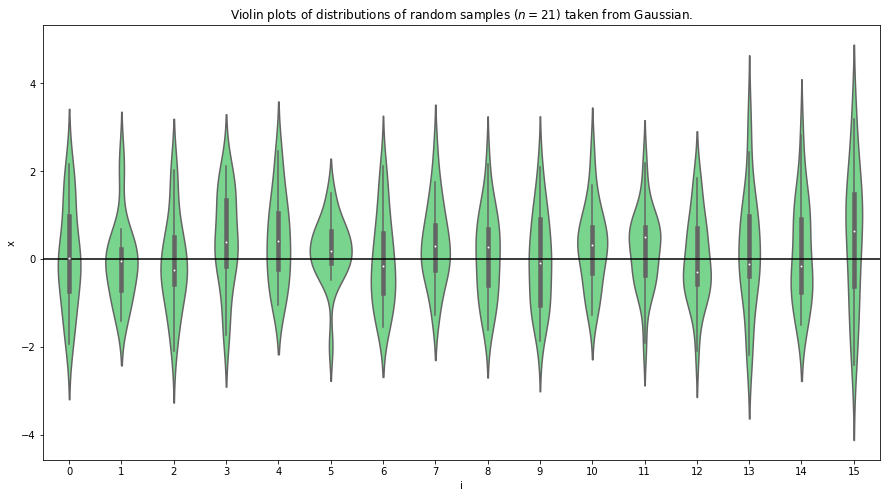

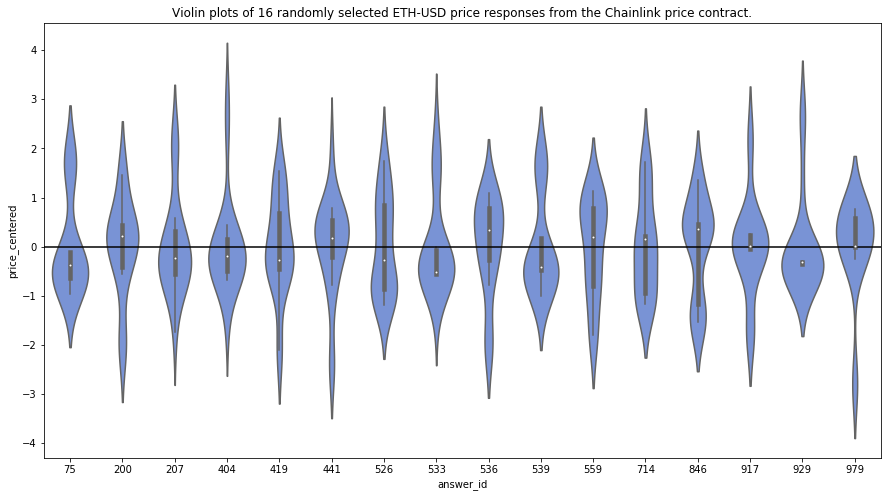

In [10]:
###
### violin plots for further visual study
###

# Plot #1: Gaussians
f, ax = plt.subplots(1, 1, figsize=(15,8))
g = sns.violinplot(
    ax=ax,
    x="i",
    y="x", 
    height=1, aspect=1,
    color=GREEN,
    data=df
).set_title('Violin plots of distributions of random samples ($n=21$) taken from Gaussian.')
ax = g.axes
ax.axhline(0, color='black');

# center data -> mean=0, std=1
df_responses.loc[:,'price_centered'] = df_responses.groupby('answer_id')['price_float'].transform(
    lambda x: (x - x.mean()) / x.std()
) 

# take a sample of previous rounds to simplify plotting
N_SAMPLES = 16
sample_ans_ids = df_responses['answer_id'].sample(N_SAMPLES)
df_sample = df_responses[df_responses['answer_id'].isin(sample_ans_ids)]

# Plot #2: oracle responses
_, ax = plt.subplots(1, 1, figsize=(15,8))
g = sns.violinplot(
    ax=ax,
    x="answer_id",
    y="price_centered",
    height=1,
    aspect=1,
    color=CHAINLINK_BLUE_LIGHT,
    data=df_sample
).set_title('Violin plots of {} randomly selected ETH-USD price responses from the Chainlink price contract.'.format(N_SAMPLES))
ax = g.axes
ax.axhline(0, color='black');

### Observations & Thoughts
* Note: the above distributions of price responses are centered (i.e. mean=0, std=1), so they hide any differences in variance between rounds. This is done so we can focus on the *shape* of the distributions.
* They look pretty okay, but let's focus on how they're different from samples drawn from normals.
     * They tend to be more skewed. See how the mode is rarely at the mean (grey line) compared to the true Gaussian distributions in green? 
     * About half of the time, they tend to have a sperm-like appearance. Yes, that's a technical term. They typically have these long tails on one end.
* We will address potential reasons for why these response distributions are skewed and multimodal in proceeding sections where we look at the variance of the responses.

## 2. Exploring variance in responses<a class="anchor" id="2"></a>
We are interested in measuring the variance of responses across rounds. We also care about *why* the responses vary; i.e. what percentage of the variance can be explained?

## 2.1 A visual study<a class="anchor" id="2.1"></a>
We again start with a comparison to same-size samples drawn from a Gaussian.

In [11]:
NSAMPLES = 20
df_norm = generate_random_gaussians(21, NSAMPLES)

Drawing 20 random samples (n=21) from Gaussian


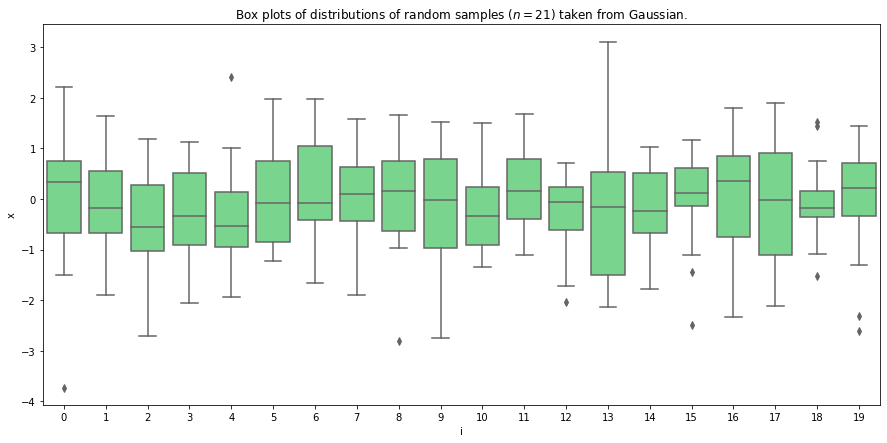

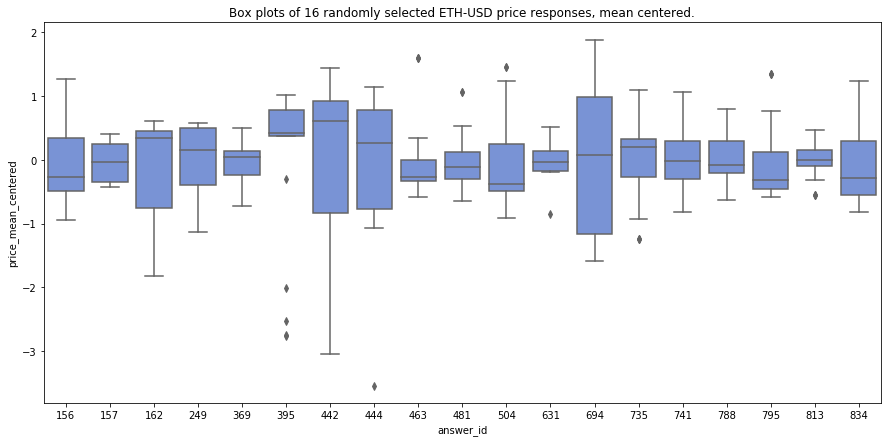

In [12]:
#
# plotting box plots for randomly selected rounds,
# and comparing them to Gaussians
#

### random samples from gaussian
_, ax = plt.subplots(1, 1, figsize=(15,7))
g = sns.boxplot(
    ax=ax,
    x="i",
    y="x",
    color=GREEN,
    data=df_norm
).set_title('Box plots of distributions of random samples ($n=21$) taken from Gaussian.'.format(N_SAMPLES))

# mean center -> mean=0, keep variace the same
# this is done so we can more easily compare differences in variance
df_responses.loc[:,'price_mean_centered'] = df_responses.groupby('answer_id')['price_float'].transform(
    lambda x: x - x.mean()
) 
# randomly select `NSAMPLES` rounds
sample_ans_ids = df_responses['answer_id'].sample(NSAMPLES)
df = df_responses[df_responses['answer_id'].isin(sample_ans_ids)]

_, ax = plt.subplots(1, 1, figsize=(15,7))
g = sns.boxplot(
    ax=ax,
    x="answer_id",
    y="price_mean_centered",
    color=CHAINLINK_BLUE_LIGHT,
    data=df
).set_title('Box plots of {} randomly selected ETH-USD price responses, mean centered.'.format(N_SAMPLES))

We add a statistical test to confirm our visual inspection. That is, we test for a significant difference in variance between rounds. We do this by testing every {2,3,4,5} consecutive rounds to see if they have the same variance, and then returning the % success rate of this test. Note that this is a relatively conservative test (compared to the various other ways we could test for a significant difference between variation in rounds), we'd expect consecutive rounds to have similar variance.

Note: we use the Fligner-Killeen test because it's non-parametric and robust against departures from normality.

In [33]:
PVALUE = 0.001
# Note, since we're doing multiple tests, it's important to adjust the p-value;
# I didn't do this formally, but I think 0.001 is small/good enough for our purposes 
prices_per_round = df_responses.sort_values('answer_id').groupby('answer_id').agg({'price_float': lambda x: list(x)}).values
prices_per_round = [x[0] for x in prices_per_round]
# NOTE: let's ignore first 100;
# the first couple are clear outliers (e.g. long round lengths; due to testing?)
# also, later rounds are much more frequent
prices_per_round = prices_per_round[100:]
res = []
NROUNDS = [2,3,4,5,6,7,8,9,10]
for n in NROUNDS:
    rng = range(len(prices_per_round)-n)
    res.append([stats.fligner(*prices_per_round[i:i+n]) for i in rng])
for n,r in zip(NROUNDS, res):
    print('percent of consecutive rounds of {n} with significantly different variance'.format(n=n))
    print('{:.2f}%'.format(100 * sum(1 for x in r if x.pvalue < PVALUE) / len(r)))

percent of consecutive rounds of 2 with significantly different variance
1.93%
percent of consecutive rounds of 3 with significantly different variance
3.62%
percent of consecutive rounds of 4 with significantly different variance
6.65%
percent of consecutive rounds of 5 with significantly different variance
10.17%
percent of consecutive rounds of 6 with significantly different variance
14.18%
percent of consecutive rounds of 7 with significantly different variance
17.23%
percent of consecutive rounds of 8 with significantly different variance
20.17%
percent of consecutive rounds of 9 with significantly different variance
23.48%
percent of consecutive rounds of 10 with significantly different variance
26.55%


Again, let me informally compare results to Gaussian (to test the quality of this test). A Gaussian shouldn't have *any* differences in variance.

In [37]:
# make gaussians same shape as `prices_per_round`
gaussians = []
for l in tqdm(prices_per_round):
    gaussians.append(generate_random_gaussians(len(l), 1, verbose=False))

gs = [dist.x.values.tolist() for dist in gaussians]
res = []
for n in NROUNDS:
    rng = range(len(gs)-n)
    res.append([stats.fligner(*gs[i:i+n]) for i in rng])
for n,r in zip(NROUNDS, res):
    print('percent of consecutive rounds of {n} with significantly different variance'.format(n=n))
    print('{:.2f}%'.format(100 * sum(1 for x in r if x.pvalue < PVALUE) / len(r)))

TypeError: generate_random_gaussians() got an unexpected keyword argument 'verbose'

Okay, so our test seems good! That is, no adjustments of the results seem necessary.

### Observations & Thoughts
* First, note that the oracle responses in our boxplot graphs are mean centered. This is done to emphasize the difference in variance between rounds.
* From an informal, visual inspection:
    * We have what appears might be a significant difference between variances in our oracle responses. Box plot ranges and IQRs appears to vary more than the Gaussians (in green). We confirm this with a statistical test.
    * We again see some examples of a skew - the "line" in the box plot is often far from the center of the rectangle.
    * We see some clear outliers.
* A significant difference in variances is confirmed with a statistical test (Fligner-Killeen).

## 2.2 Exploring causes of variance<a class="anchor" id="2.2"></a>
We analyze how the following factors affect the variance of oracle responses, for a given round:
* the length of a round
* variance of reporting times
* price volatility of asset (during the round)
How much do these factors influence the variability in responses.

### Getting the data

Price data.

In [65]:
### load price data gathered from the CryptoCompare API
df_prices = pd.read_csv('eth-usd_prices.csv')

In [66]:
# remove volumefrom == 0, which signifies current, unfinished round
df_prices = df_prices[df_prices.volumefrom > 0]
df_prices

,time,high,low,open,volumefrom,volumeto,close
0,1.587418e+09,172.75,172.62,172.70,208.92,36074.60,172.67
1,1.587418e+09,172.67,172.58,172.67,209.92,36229.88,172.61
2,1.587418e+09,172.66,172.52,172.57,260.20,44925.51,172.66
3,1.587418e+09,172.65,172.52,172.65,727.86,125451.16,172.55
4,1.587418e+09,172.45,172.04,172.41,979.73,168555.60,172.04
...,...,...,...,...,...,...,...
26195,1.589079e+09,189.13,188.91,188.91,589.10,111386.17,189.11
26196,1.589079e+09,189.11,188.93,189.11,619.64,117125.60,188.93
26197,1.589079e+09,189.05,188.92,188.93,662.51,125210.41,188.98
26198,1.589079e+09,189.01,188.84,188.94,442.92,83716.77,189.01


Round metrics.

In [109]:
### load various metrics pertaining to a rounds
df_rounds = load_round_metrics(df_prices, df_responses)

Getting start times of rounds...
First block: 2020-05-09 16:28:08.
Round 1021 USD-ETH price response: 2020-05-10 03:15:55.
Querying blockchain in chunks of 2000 blocks. 2 chunks total.



Done.
Converting block numbers to timestamps...



Augmenting round data...
Computing length of rounds...
Computing standard deviation of response times...
Computing standard deviation of prices...
Computing price volatility...


/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [110]:
# compute per round: std of response times, std of price, std of block time
df_rounds[['response_std_ts', 'response_std_price', 'response_std_block_time']] = df_responses.\
        sort_values(by=['timestamp']).\
        drop_duplicates(subset=['answer_id', 'oracle'], keep='last').\
        groupby('answer_id').\
        agg(np.std)[['timestamp', 'price_float', 'blockNumber']]

In [111]:
### removing clear outliers
# only include finished rounds
df_rounds = df_rounds[df_rounds.ts_end > 0]
# - also, first two rounds are exeedingly long (probably some test runs)
df_rounds.drop(2, inplace=True)
df_rounds.drop(3, inplace=True)
# remove any rounds with price std > $10; clear outlier
df_rounds = df_rounds[df_rounds['response_std_price'] < 10]
# remove any rounds with response time > 1 day; clear outlier
df_rounds = df_rounds[df_rounds['response_std_ts'] < 60*60*24]

In [114]:
df_rounds = df_rounds.drop_duplicates()
df_rounds

,block_number,ts_start,ts_end,round_length,response_std_ts,response_std_price,volatility,response_std_block_time
round_id,,,,,,,,
4,9837987,1586434798,1586438780,3982,33.924145,0.215972,NaN,1.502379
5,9838260,1586438625,1586441008,2383,24.395647,0.179356,NaN,3.005550
6,9838425,1586440886,1586447252,6366,17.028268,0.268847,NaN,1.091089
7,9838903,1586447154,1586448061,907,5.353682,0.314477,NaN,1.458962
8,9838959,1586448013,1586455311,7298,21.059214,0.198109,NaN,1.152637
...,...,...,...,...,...,...,...,...
1014,10035049,1589068127,1589069032,905,34.081206,0.491130,0.271106,2.951997
1016,10035202,1589070248,1589072037,1789,1384.636787,3.072579,1.189909,107.867004
1017,10035229,1589070664,1589072642,1978,1010.491637,0.815792,0.780893,74.464021


### 2.2.1 Price volatility, round duration, and dispersion of response times<a class="anchor" id="2.2.1"></a>

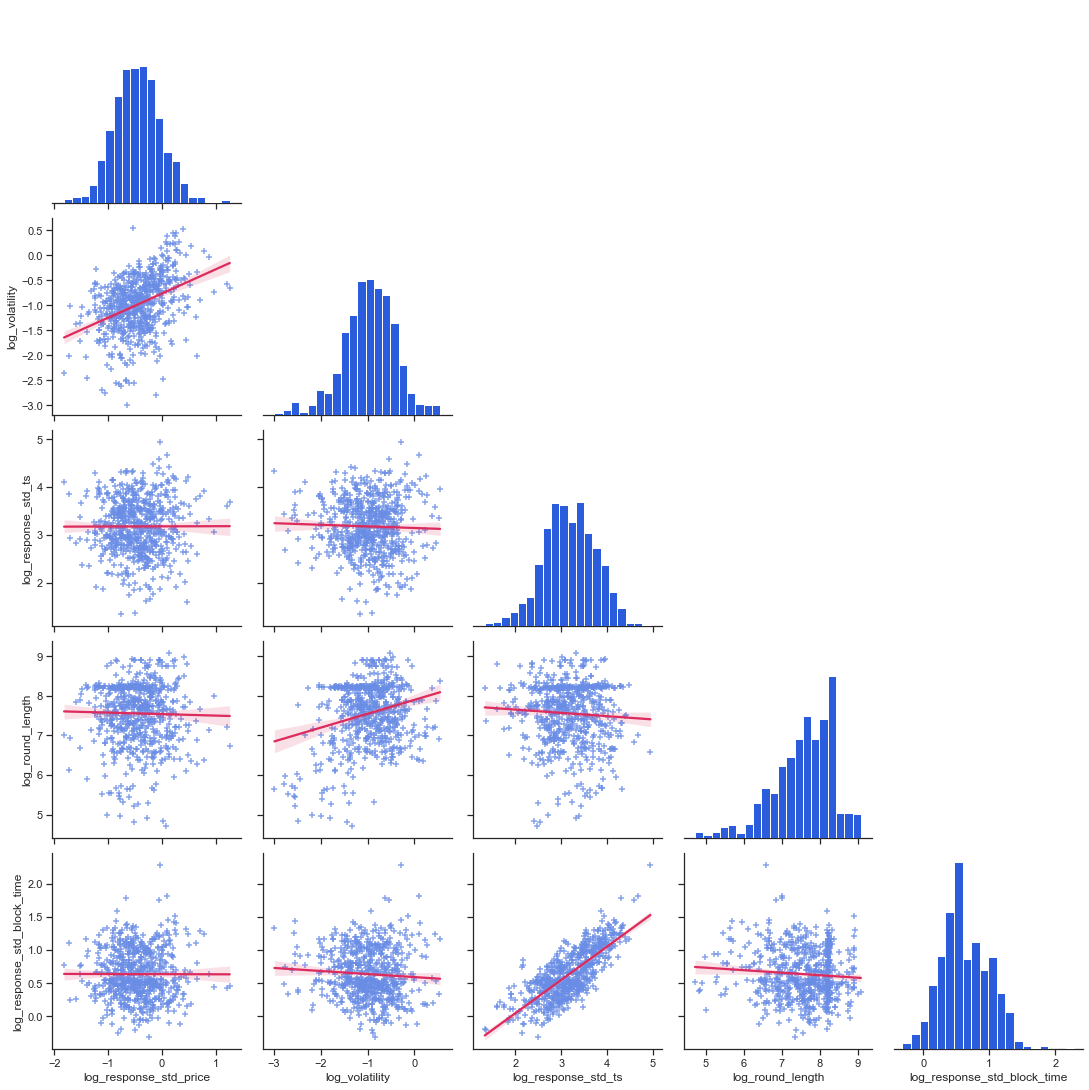

In [115]:
'''
TODO:
- we don't want timestamps to be the only measure of response times
- timestamps are approximated from the block number where response is located
- want to also include "block distance"
'''
df = pd.DataFrame()
### all variables need a log transform
df['log_response_std_price'] = np.log(df_rounds['response_std_price'])
df['log_volatility'] = np.log(df_rounds['volatility'])
df['log_response_std_ts'] = np.log(df_rounds['response_std_ts'])
df['log_round_length'] = np.log(df_rounds['round_length'])
df['log_response_std_block_time'] = np.log(df_rounds['response_std_block_time'])

### removing some clear outliers after first plotting the data
df = df[df['log_response_std_ts'] < 5]
df = df[df['log_volatility'] > -3]

df = df.dropna()

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(
    df, diag_kind="hist", kind="reg", markers="+", height=3,
    palette='Blues',
    corner=True,
    diag_kws={'bins':20, 'color': CHAINLINK_BLUE},
    plot_kws={'color': CHAINLINK_BLUE_LIGHT, 'line_kws':{'color':RED}}
)

Confirm correlations with stats test:

In [116]:
def spearmanr_pval(x,y):
    return stats.spearmanr(x,y)[1]
corrs = df.corr(method='spearman')
pvalues = df.corr(method=spearmanr_pval)
df_ = pd.DataFrame()
for col in corrs.columns:
    df_[col] = list(zip(corrs[col], pvalues[col]))

def highlight_significant(x, y, pvalue=0.001):
    '''
    highlight only significant correlations
    '''
    if pvalues.loc[x, y] < pvalue:
        return 'background-color: #FFFF93'
    return ''

corrs.style.format("{:.3}")
#corrs.style.apply(highlight_significant, axis=1)
print('correlation coefficients, with significant values (p < 0.001) highlighted')
corrs.style.apply(lambda x: pd.DataFrame(x).apply(lambda y: highlight_significant(x.name, y.name), axis=1))

correlation coefficients, with significant values (p < 0.001) highlighted


,log_response_std_price,log_volatility,log_response_std_ts,log_round_length,log_response_std_block_time
log_response_std_price,1.000000,0.385367,-0.012115,-0.029800,-0.028558
log_volatility,0.385367,1.000000,-0.030600,0.096397,-0.094638
log_response_std_ts,-0.012115,-0.030600,1.000000,-0.022023,0.749557
log_round_length,-0.029800,0.096397,-0.022023,1.000000,-0.044723
log_response_std_block_time,-0.028558,-0.094638,0.749557,-0.044723,1.000000


We show that price volatility is strongly correlated (`Spearmanr=0.40`) with dispersion in response time. Dispersion in response time is strongly correlated with dispersion in block time (as expected, since timestamps are computed from block numbers); *however* the correlation is not quite close to 1, because blocks are not mined at consistent intervals.

### Observations \& Comments
* Price volatility is strongly correlated with variance in (price) responses.
* There is evidence to believe (and intuition would agree) that variance in responses is also positively correlated with variance in response times; however, we were unable to show this relationship with statistical significance.
    * **Note**: This is likely due to the fact that timestamps are approximated from block numbers and many responses are mined on the same block (i.e. these timestamps are a crude measure of when the oracle *actually* responded). Blocks take anywhere from 1-30min to mine. Further, it's possible for a submitted response to be mined after a response that is submitted much later (which depends on how much gas they pay as well as general asynchrony in the network).
* Round length produces strange results (e.g. negative correlation with variance in responses). This is most likely due to it's weird distribution, which is due to the fact that most rounds are similar length which prevents us from discovering how *change* in length affects other factors.
* *Weird:* longer rounds are associated with lower variance in prices and response times. TODO: look into this.

### 2.2.2 Multivariate regression<a class="anchor" id="2.2.2"></a>

In [120]:
X = df[['log_volatility', 'log_response_std_ts', 'log_response_std_block_time', 'log_round_length']]
X = sm.add_constant(X)
y = df['log_response_std_price']

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     log_response_std_price   R-squared:                       0.166
Model:                                OLS   Adj. R-squared:                  0.161
Method:                     Least Squares   F-statistic:                     31.98
Date:                    Sat, 09 May 2020   Prob (F-statistic):           2.49e-24
Time:                            23:28:17   Log-Likelihood:                -335.49
No. Observations:                     649   AIC:                             681.0
Df Residuals:                         644   BIC:                             703.3
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.4182      0.205      2.041      0.042       0.016       0.820
log_volatility                  0.3376      0.030     11.293      0.000       0.279       0.396
log_response_std_ts            -0.0079      0.044     -0.179      0.858      -0.095       0.079
log_response_std_block_time     0.0293      0.069      0.428      0.669      -0.105       0.164
log_round_length               -0.0704      0.021     -3.332      0.001      -0.112      -0.029
==============================================================================
Omnibus:                       11.768   Durbin-Watson:                   0.893
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.083
Skew:                           0.202   Prob(JB):                     0.000531
Kurtosis:                       3.629   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Comments

We see that **16.7%** of the variance in our price data can be explained by *price volatility*, *variance in response times*, *variance in block numbers*, and *round length*; although it seems that only volatility and round lengths are significant contributors. *Very strangely:* round length is negatively correlated with price variance; we'd expect longer rounds to have more variance, but this doesn't seem to be the case. With that said, by closely observing the correlation graphs, I'm inclined to believe this is a spurious result.

### 2.2.3 How much do individual oracles have an effect on variability?<a class="anchor" id="2.2.3"></a>
The only other information that I felt could explain some of the variability in responses, is the oracles themselves. Do some oracles provide poorer responses (i.e. more distant from the others)? We test this quite crudely using individual oracles as dummy variables, but I don't this an ideal method, as I will explain below.

**Which oracles are furthest from mean?**
Formally: look at distribution of std from mean per oracle.

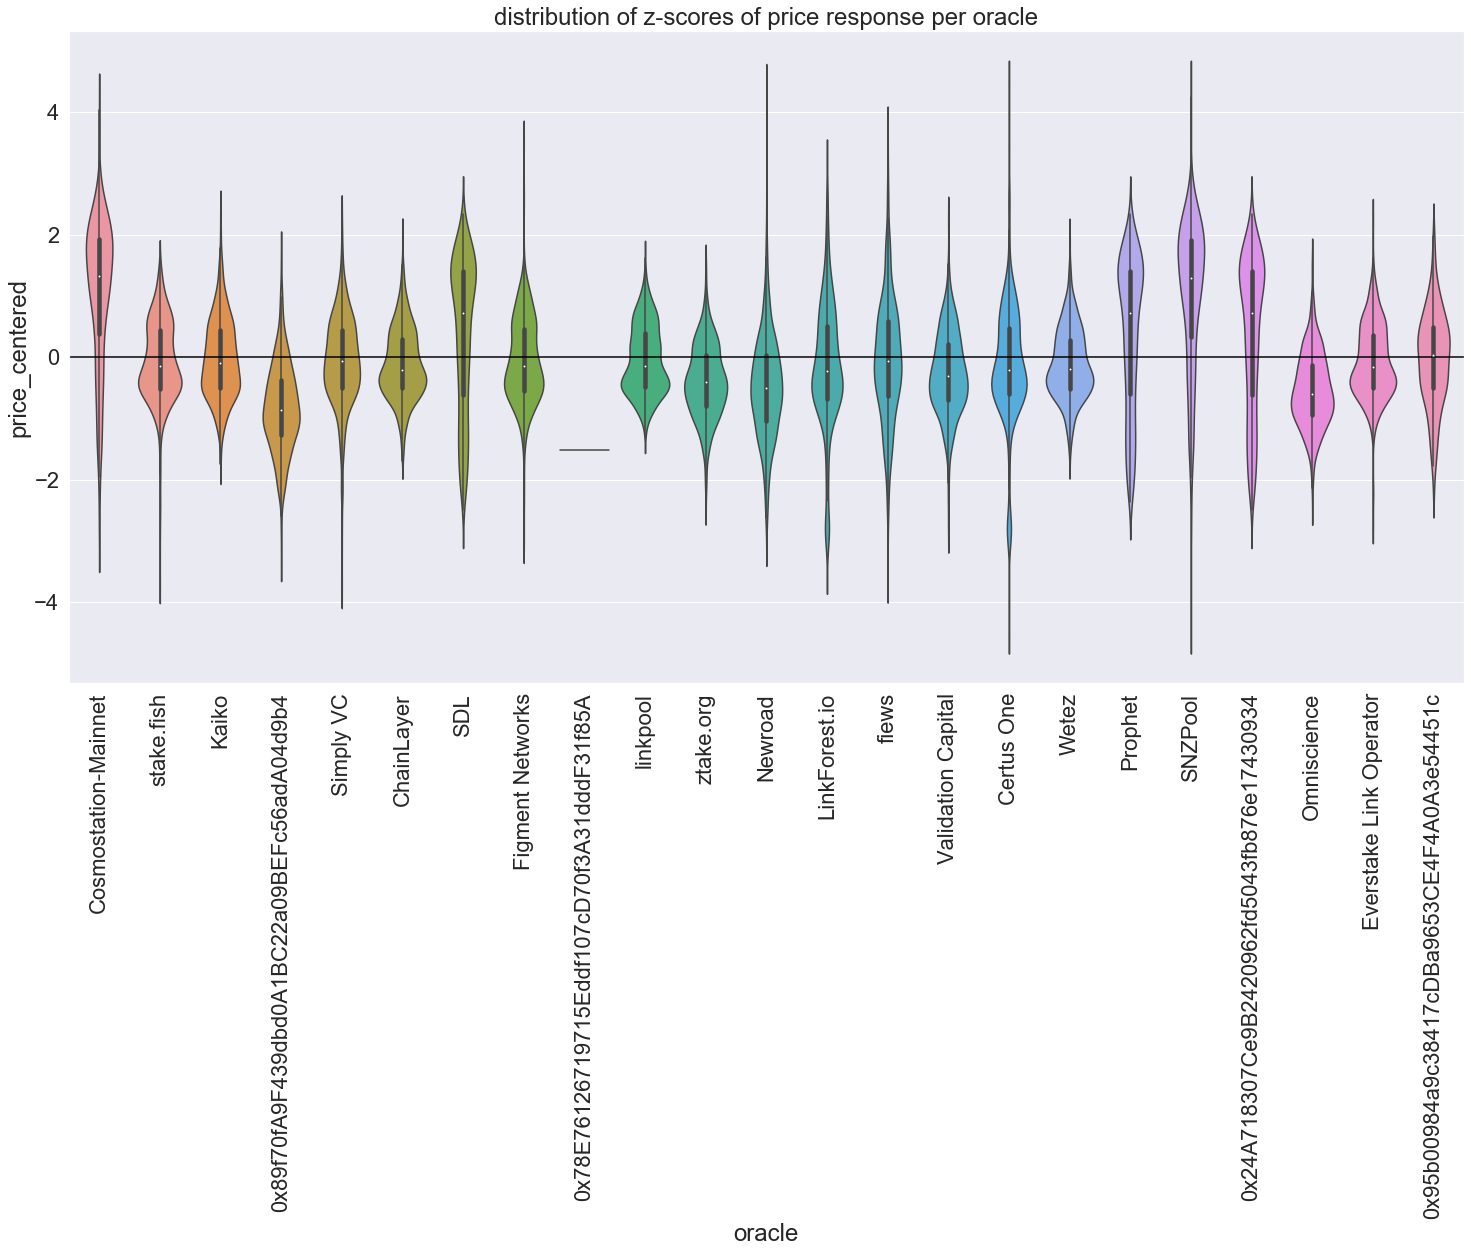

In [134]:
# note: previously computed "price centered" *is* the z-score
df_responses.loc[:,'price_centered'] = df_responses.groupby('answer_id')['price_float'].transform(
    lambda x: (x - x.mean()) / x.std()
)
_, ax = plt.subplots(1, 1, figsize=(25,12))
g = sns.violinplot(x="oracle", y="price_centered", data=df_responses, ax=ax, palette=PALLETTE_10)
ax = g.axes
ax.axhline(0, color='black');
labels = [oracles.get(x.get_text(), x.get_text()) for x in g.get_xticklabels()]

g.set_xticklabels(labels, rotation=90);
g.set_title('distribution of z-scores of price response per oracle');
sns.set_style("whitegrid")
sns.set(font_scale = 2)
#plt.title("accuracy of response as a function of response time", fontsize=20)
#plt.ylabel("absolute distance from median (\$USD)", fontsize=17)

Note: `0x78E76126719715Eddf107cD70f3A31dddF31f85A` is an oracle with only one response ever, thus it's "distribution" is a single point.

In [138]:
df = pd.concat([df_responses['answer_id'], pd.get_dummies(df_responses['oracle'], prefix='oracle')], axis=1)
df = df.groupby('answer_id').sum()
df = df_rounds.join(df)

oracles = [c_ for c_ in df if c_.startswith('oracle')]
# this oracle has only one response
oracles.remove('oracle_0x78E76126719715Eddf107cD70f3A31dddF31f85A')

subset = df[[*oracles]]

model = sm.OLS(endog=df['response_std_price'], exog=subset, missing='drop')
results = model.fit()
results.summary(alpha=0.1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     response_std_price   R-squared (uncentered):                   0.789
Model:                            OLS   Adj. R-squared (uncentered):              0.785
Method:                 Least Squares   F-statistic:                              185.0
Date:                Sat, 09 May 2020   Prob (F-statistic):                   5.55e-317
Time:                        23:50:29   Log-Likelihood:                         -372.72
No. Observations:                1008   AIC:                                      785.4
Df Residuals:                     988   BIC:                                      883.8
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================================
                                                        coef    std err          t      P>|t|       [0.05       0.95]
---------------------------------------------------------------------------------------------------------------------
oracle_0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484    -0.5994      0.409     -1.467      0.143      -1.272       0.073
oracle_0x0Ce0224ba488ffC0F46bE32b333a874Eb775c613    -0.8003      0.172     -4.664      0.000      -1.083      -0.518
oracle_0x240BaE5A27233Fd3aC5440B5a598467725F7D1cd     1.0790      0.580      1.861      0.063       0.124       2.034
oracle_0x24A718307Ce9B2420962fd5043fb876e17430934     0.0510      0.466      0.109      0.913      -0.716       0.818
oracle_0x2Ed7E9fCd3c0568dC6167F0b8aEe06A02CD9ebd8     0.8559      0.586      1.460      0.145      -0.109       1.821
oracle_0x38b6ab6B9294CCe1Ccb59c3e7D390690B4c18B1A     0.1620      0.731      0.222      0.825      -1.041       1.365
oracle_0x4565300C576431e5228e8aA32642D5739CF9247d    -0.5994      0.409     -1.467      0.143      -1.272       0.073
oracle_0x58c69aFF4Df980357034eA98AaD35bbF78cBD849     0.3434      0.354      0.970      0.332      -0.239       0.926
oracle_0x64FE692be4b42F4Ac9d4617aB824E088350C11C2     0.1908      0.480      0.398      0.691      -0.599       0.981
oracle_0x79C6e11bE1C1ed4D91FbE05D458195A2677F14A5    -1.0588      0.954     -1.110      0.267      -2.629       0.512
oracle_0x7A9d706B2A3b54f7Cf3b5F2FcF94c5e2B3d7b24B    -0.1861      0.142     -1.315      0.189      -0.419       0.047
oracle_0x7e94A8A23687D8C7058Ba5625dB2Ce358bCbd244     0.4061      0.304      1.338      0.181      -0.094       0.906
oracle_0x83dA1beEb89Ffaf56d0B7C50aFB0A66Fb4DF8cB1     0.0163      0.111      0.147      0.883      -0.166       0.198
oracle_0x85aEace84a130bC1AcCcE2a9F4F933F6765b0B9B     0.8895      0.801      1.111      0.267      -0.429       2.208
oracle_0x89f70fA9F439dbd0A1BC22a09BEFc56adA04d9b4     0.1919      0.471      0.407      0.684      -0.584       0.968
oracle_0x8c85a06EB3854Df0d502B2b00169DBfB8B603Bf3     0.0715      0.038      1.885      0.060       0.009       0.134
oracle_0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a    -0.2610      0.305     -0.855      0.393      -0.764       0.242
oracle_0x95b00984a9c38417cDBa9653CE4F4A0A3e54451c     0.4370      0.469      0.931      0.352      -0.335       1.209
oracle_0x992Ef8145ab8B3DbFC75523281DaD6A0981891bb    -0.9523      0.543     -1.753      0.080      -1.847      -0.058
oracle_0xB92ec7D213a28e21b426D79EDe3c9BBcf6917c09     0.8559      0.586      1.460      0.145      -0.109       1.821
oracle_0xF3b450002C7Bc300eA03c9463d8E8BA7f821b7c6    -0.2597      0.432     -0.602      0.548      -0.970       0.451
oracle_0xF5a3d443FccD7eE567000E43B23b0e98d96445CE     0.2129      0.615      0.346      0.729      -0.799       1.225
==================================

### Observations & Comments

Quick notes (TODO: add more detail later):
* ~79% of variance can be explained by the oracles themselves
* yes, multicollinearity, but this doesn't affect following results: % variance explained by *all* variables, individual significant results
* some oracles (with confidence intervals fully in positive or negative), show significant impact on variance of price responses; **however** this doesn't immediately imply these oracles are "good/bad" ... long statistical explanation omitted .. 

Note: this isn't an ideal test to see individual oracle effects on price variablity. This is because most of the oracles respond most of the time, so it's hard to judge their effect when modeled as dummy variables. (I included these results because I think it's important to be honest and include all tests, not just those with significant results.)

### 2.2.4 What about data sources?

In [55]:
# info scraped from https://market.link/
# information is *inferred*, thus,
# ultimately, we don't know how oracles compute the final price

# note: I think oracles without any price adapters listed,
# are probably just doing HTTP requests

oracles = {
    '0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484': 'fiews',
    '0x240BaE5A27233Fd3aC5440B5a598467725F7D1cd': 'linkpool',
    '0xF5a3d443FccD7eE567000E43B23b0e98d96445CE': 'ChainLayer',
    '0xF3b450002C7Bc300eA03c9463d8E8BA7f821b7c6': 'Newroad',
    '0x83dA1beEb89Ffaf56d0B7C50aFB0A66Fb4DF8cB1': 'Omniscience',
    '0x7A9d706B2A3b54f7Cf3b5F2FcF94c5e2B3d7b24B': 'LinkForest.io',
    '0x4565300C576431e5228e8aA32642D5739CF9247d': 'Certus One',
    '0x38b6ab6B9294CCe1Ccb59c3e7D390690B4c18B1A': 'Prophet',
    '0xB92ec7D213a28e21b426D79EDe3c9BBcf6917c09': 'stake.fish',
    '0x7e94A8A23687D8C7058Ba5625dB2Ce358bCbd244': 'SNZPool',
    '0x58c69aFF4Df980357034eA98AaD35bbF78cBD849': 'Wetez',
    '0x79C6e11bE1C1ed4D91FbE05D458195A2677F14A5': 'Validation Capital',
    '0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a': 'Simply VC',
    '0x8c85a06EB3854Df0d502B2b00169DBfB8B603Bf3': 'Kaiko',
    '0x85aEace84a130bC1AcCcE2a9F4F933F6765b0B9B': 'Everstake Link Operator',
    '0x992Ef8145ab8B3DbFC75523281DaD6A0981891bb': 'Figment Networks',
    '0x2Ed7E9fCd3c0568dC6167F0b8aEe06A02CD9ebd8': 'SDL',
    '0x64FE692be4b42F4Ac9d4617aB824E088350C11C2': 'ztake.org',
    '0x0Ce0224ba488ffC0F46bE32b333a874Eb775c613': 'Cosmostation-Mainnet',
}

data_sources = {
    '0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484': [
        'CoinMarketCap',
        'nomics',
        'Coinpaprika',
        'Alpha Vantage'
    ],
    '0x240BaE5A27233Fd3aC5440B5a598467725F7D1cd': [
        'CryptoCompare',
        'assetprice',
        'CoinMarketCap',
        'cryptoapis',
        'web3api',
        'CoinGecko',
        'Brave New Coin',
    ],
    '0xF5a3d443FccD7eE567000E43B23b0e98d96445CE': [
        'Brave New Coin',
        'CoinGecko'
        'Kaiko',
        'CryptoCompare',
        'Alpha Vantage',
        'Coinpaprika',
        'web3api',
        'CoinCap',
    ],
    '0xF3b450002C7Bc300eA03c9463d8E8BA7f821b7c6': [
        'CoinMarketCap'
    ],
    '0x83dA1beEb89Ffaf56d0B7C50aFB0A66Fb4DF8cB1': [
        'CryptoCompare',
        'AlphaVantage',
        '1Forge',
        'CoinGecko',
        
    ],
    '0x7A9d706B2A3b54f7Cf3b5F2FcF94c5e2B3d7b24B': [
        'CoinApi'
    ],
    '0x4565300C576431e5228e8aA32642D5739CF9247d': [
        'CoinGecko'
    ],
    '0x38b6ab6B9294CCe1Ccb59c3e7D390690B4c18B1A': [
        'Coinpaprika',
        'CryptoCompare',
        'Open Exchange Rates',
        'Alpha Vantage',
        'apilayer'
    ],
    '0xB92ec7D213a28e21b426D79EDe3c9BBcf6917c09': [
        'CryptoCompare'
    ],
    '0x7e94A8A23687D8C7058Ba5625dB2Ce358bCbd244': [
        'CoinMarketCap'
    ],
    '0x79C6e11bE1C1ed4D91FbE05D458195A2677F14A5': [
        'CoinGecko'
    ],
    '0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a': [
        'CryptoCompare',
        'cryptoapis'
    ],
    '0x58c69aFF4Df980357034eA98AaD35bbF78cBD849': [
        'CoinCap',
        'CoinGecko'
    ],
    '0x8c85a06EB3854Df0d502B2b00169DBfB8B603Bf3': [
        'Kaiko'
    ],
    '0x85aEace84a130bC1AcCcE2a9F4F933F6765b0B9B': [], # none listed
    '0x992Ef8145ab8B3DbFC75523281DaD6A0981891bb': [], # none listed
    '0x2Ed7E9fCd3c0568dC6167F0b8aEe06A02CD9ebd8': [], # none listed
    '0x64FE692be4b42F4Ac9d4617aB824E088350C11C2': [
        'CryptoCompare'
    ],
    '0x0Ce0224ba488ffC0F46bE32b333a874Eb775c613': [
        'CoinMarketCap'
    ]
}

### Conclusions

The only thing we can *confidently* state, regarding causes of response variability per round, is that *price volatility* and *variability in response times* show siginificant effects, combined explaining around 17% of the variability of the data. 

A very interesting point is that it isn't clear what the causal mechanism is precisely for price volatility → response variability, since oracles are reporting the price of ETH as well as partaking in a network whose functioning is affected by the price of ETH. Consider the following:

* ETH-USD price volatility during a round creates more opportunities for oracles to respond with different answers, simply because the variable they are reporting takes on many values within the period of interest.
* ETH-USD volatility is a known cause of high gas prices in the Ethereum network. This might cause rounds to take longer to complete, thereby increasing the amount of time oracles have to report, increasing the variability of responses.
    * I should really do this analysis with another price pair to decouple these two causes, but, then again, any volatile price pair is probably also correlated with volatility in ETH-USD ..

**Note**: It's very likely that price response times are a stronger cause of variability than we were able to detect with the tests above. We are unable to precisely capture this information because we don't know the exact time a price was reported by an oracle. The timestamp of a response is calculated from it's block number. And a block can take anywhere from 15 seconds to 30 minutes to mine (see: https://ethgasstation.info/).

## 2.3 Relationship between response time and accuracy of response<a class="anchor" id="2.3"></a>
Next, we look at how the response time affects the accuracy of response. Response time is measured by percentage rank; e.g. a percentage rank of 20% means that an oracle responded after 20% of all oracles in that round; a rank percent of 0 means an oracle was (one of) the first to respond. Accuracy of response is the absolute distance from the median response, so, in this case, the unit of measure is $USD. We measure "accuracy" by how close the response is to the median. This isn't an ideal measure of accuracy as will be explained in the discussion section at the end. Assume it's a good measure for now.

**Note**:
* at first, we might not expect there to be a relationship at all. An oracle is free to respond at any point in the round; it doesn't immediately make sense that it's particular reponse time (e.g. whether it was first, third, or tenth) should have an effect on its accuracy. We will see that this relationship does, in fact, exist.
* a lot of oracles respond at the same time, thus resulting in the same percent rank, thus resulting in a max percent rank less than 1 (most of the time, max percent rank is around 30%)

In [1168]:
def ts_percentile(row):
    rnd = int(row['answer_id'])
    return (row['timestamp'] - df_rounds.loc[rnd]['ts_start']) / df_rounds.loc[rnd]['round_length']

def dist_from_median(row):
    df = df_responses
    df = df[df['answer_id'] == row['answer_id']]
    med = np.median(df['price_float'])
    return row['price_float'] - med

df = df_responses

# compute ranks
df['ts_rank_pct'] = df.groupby(['answer_id']).agg(
    count_col=pd.NamedAgg(column='timestamp', aggfunc="rank")
)
df.rename(columns={'count_col': 'ts_rank_pct'}, inplace=True)
# compute response's distance from median response
df['dist_from_median'] = df_responses.apply(lambda row: dist_from_median(row), axis=1)

# only inlude rounds where there is a good seperation of timestamps
df = df.groupby('answer_id').filter(lambda g: (g.ts_rank_pct > 20).any())

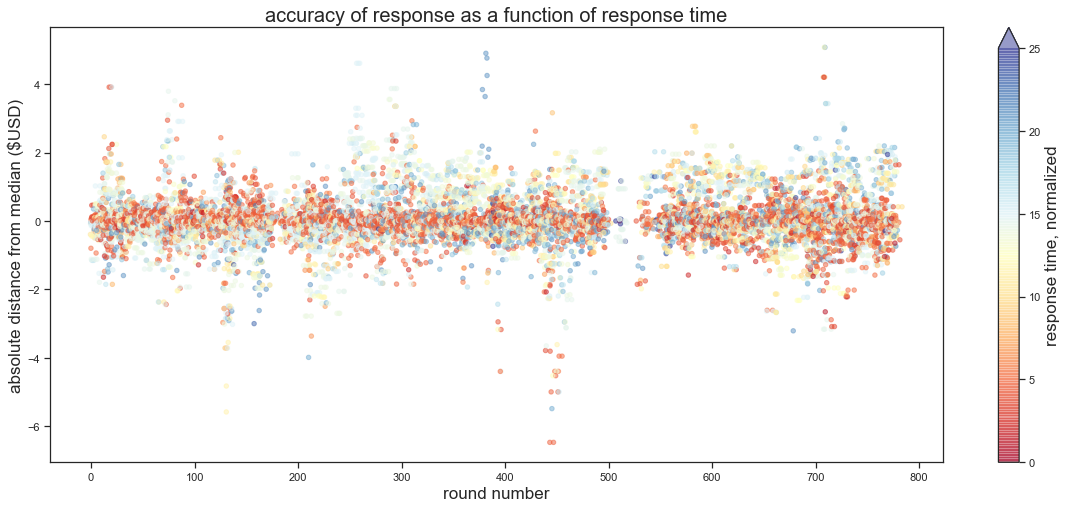

In [1170]:
# I'll be plotting this a few times,
# so might as well make a function
def plot(df, cmap='RdYlBu', figsize=(20, 8)):
    plt.figure(figsize=figsize)
    def __add_jitter(x):
        # for visual ease
        std = .01 * x.std()
        return x + np.random.randn(len(x)) * std
    plt.scatter(
        add_jitter(df.answer_id),
        df.dist_from_median,
        alpha =0.5,
        c = df.ts_rank_pct,
        cmap=cmap,
        s=20
    )
    plt.title("accuracy of response as a function of response time", fontsize=20)
    plt.xlabel("round number", fontsize=17)
    plt.ylabel("absolute distance from median (\$USD)", fontsize=17)
    #cbar = plt.colorbar()
    plt.colorbar(extend='max').set_label('response time, normalized', fontsize=17)
    plt.clim(0, 25);

plot(df)

Removing outlier-ish data (points more than \$2) from median.

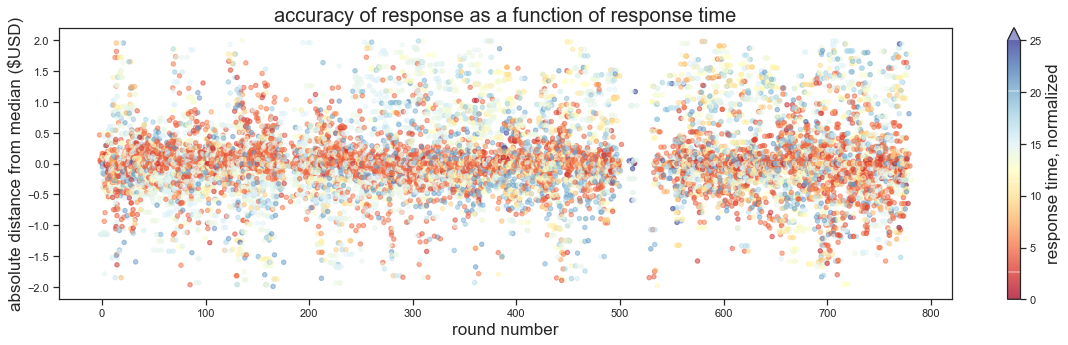

In [1171]:
df = df[(-2 <= df.dist_from_median) & (df.dist_from_median <= 2)]
plot(df, figsize=(20, 5))

And just to confirm this isn't some optical illusion with colors :), we reverse the colorbar:

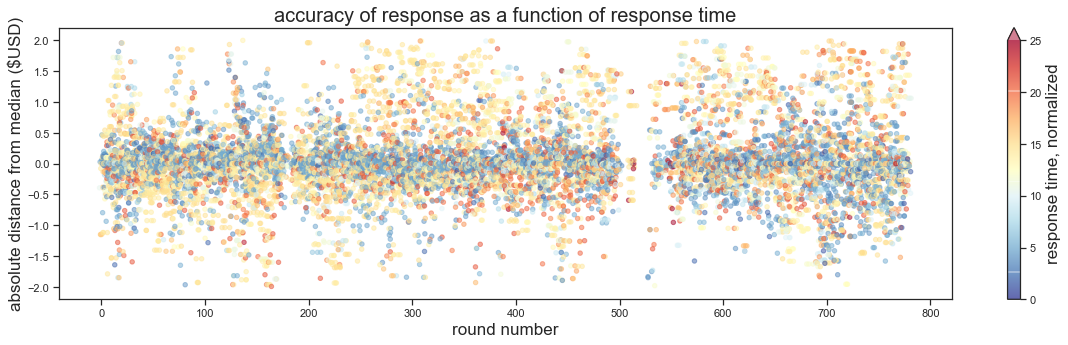

In [1172]:
plot(df, cmap='RdYlBu_r', figsize=(20, 5))

And to add some formality with a statistical test:

In [912]:
stats.spearmanr(df['ts_rank_pct'], df['dist_from_median'].abs())

SpearmanrResult(correlation=0.198867043180545, pvalue=2.7947608612527663e-125)

We have a significant and positive correlation between response time (measured by percent rank) and absolute distance from median. This seems to suggest that most responses happen at the start of the round. Let's investigate this further with the following graph.

In [146]:
# catplot of response times (blocks after start of round)
def blocks_after_start(row):
    '''
    Return the reponse time,
    measured in block numbers after start of round.
    '''
    if row['answer_id'] in df_rounds.index:
        res = row['blockNumber'] - df_rounds.loc[row['answer_id']]['block_number']
        if type(res) != np.float64:
            res = res.iloc[0]
        return res
    return np.nan

df_responses['blocks_after_start'] = df_responses.apply(lambda row: blocks_after_start(row), axis=1)

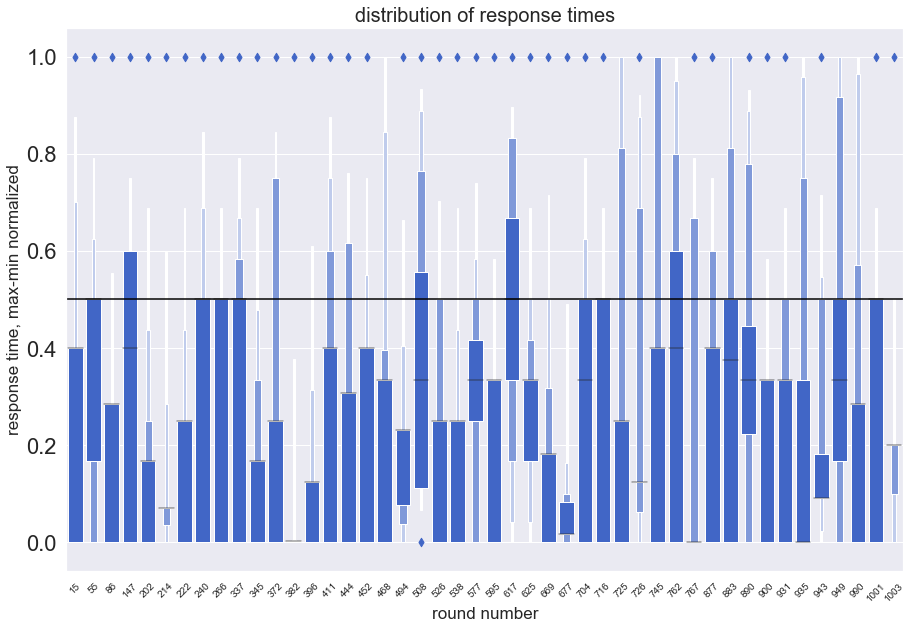

In [148]:
###
### catplot of response times (blocks after start of round)
###
df = df_responses[["answer_id", "blocks_after_start"]].dropna()
df["answer_id"] = df["answer_id"].astype('int')
df["blocks_after_start"] = df["blocks_after_start"].astype('int')
# max/min normalize for easier visual comparison
df["blocks_after_start"] = df.groupby('answer_id').transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# select a sample of rounds
N_SAMPLES = 50
sample_ans_ids = df_responses['answer_id'].sample(N_SAMPLES)
df = df[df['answer_id'].isin(sample_ans_ids)]

# plot
plt.figure(figsize=(15,10));

g = sns.boxenplot(
    x="answer_id",
    y="blocks_after_start",
    color=CHAINLINK_BLUE,
    data=df,
    # only changed to aid in visualization;
    # not a true statement about outlier proportion
    outlier_prop=0.2
)
plt.title("distribution of response times", fontsize=20);
plt.xlabel("round number", fontsize=17);
plt.ylabel("response time, max-min normalized", fontsize=17);
g.set_xticklabels(
    labels=df['answer_id'].unique(),
    fontdict={'fontsize': 10},
    rotation=45
);
ax = g.axes
ax.axhline(0.5, color='black');

Ah, so this is what likely explains our skewed distributions! Most oracles respond at the start (halfway point, in this context).

### Observations \& Conclusions
Recall: in the scatterplots, the y-axis is the distance of the response from the median (in a given round). In this context, it represents the difference in $USD between an oracle response and the median response. It measures how "off" the oracle is: closer to 0 is good, further is bad. The x-axis it the round number/ answer ID. Importantly, the color represents the percentile rank of the response's timestamp; in simple terms: smaller numbers are responses that occured first and larger numbers are responses that occured later. The scatterplot indicate that responses that occur earlier are typically the ones that are closest to the median.

The boxen plots (immediately above) confirm the assumption raised from the scatterplots, namely that most oracles respond early in the round.

We conclude:
* Oracles that respond earlier tend to be closer to the median.
* This implies that nodes that respond later are more likely to be outliers. This, again, is probably an artifact of price volatility; i.e. the longer you wait to respond, the more likely the price is to change.

# Part 3: Conclusion & Discussion, so far<a class="anchor" id="Part3"></a>

### Conclusions
* For a given round, the distribution of responses does not appear to be a unimodal normal as one would expect when sampling responses to the question "What is the value of $x$?" where $x$ in this case is the price of ETH in USD. Instead, our distributions appear multi-modal at least half of the time.
    * This multi-modality appears to be caused by oracles responding at different times in the round; thus, as the price naturally shifts, a response that occurs later in the round will most likely differ from a response made earlier.
* 17% of the variation in responses can be explained by *price volatility of ETH-USD* and *variance of reponse times*, where volatility shows to have the most significant impact. We noted before, but I'll do so again, that the way we measure response times is crude, so it remains possible that variance in response times does in fact have a greater impact than we were able to detect.
* Most oracles respond early in the round. Thus the median tends to be one of the earlier resposes. Thus responses that are furthest from the median tend to be responses that occured later in the round.
* Since we don't know where the oracles get their data from, we couldn't test this as a contributing factor to response variance.

### Discussion
Here's something that bothers me: since most oracles respond early, oracles that respond later are the ones that are most likely to be penalized. There's nothing inherently "wrong" with responding later in a round. In fact, ironically, an honest response that occurs later is most likely closer to the true value of the price at the time of aggregation and, vice versa, responses that occured earlier are more likely to be stale. If we blindly penalize "outliers" we will be likely penalizing oracles that respond later in the round.

Note: this might have something to do with the fact that price feeds are currenlty using the v4 version of the aggregator contract and not v6. With the v4 aggregator, oracles are not aware of the length of the round (there's no nice way to query this information) so oracles probably respond as soon as possible. In the v6 aggregator, oracles *can* query for the length of a round, thus, perhaps, using this aggregator would result in more of a dispersion of response times since oracles know the window they have in which to respond.

I think an ideal solution to this would be to have some mechanism that enforces or incentivizes oracles to respond at the same time. Here's a rough idea: if you were to allow oracles to *update* their responses multiple times per round (this is currently not possible; why?) then, I believe, oracles would be incentivized to update their response any time the price shifts significantly during a round (which implies more updates will occur when the price is more volatile) because they don't want to be an outlier and thus be penalized. I believe this would create something like a Shelling point around the most recent price at the end of a round. The only downside I can see to this is having to pay more for gas.

# TODO
* outlier detection stuff
* per round & across time
    * Why? Because per-round outlier detection will have more false positives & false negatives than outlier detection across multiple rounds, simply due to having less data in the former case. We should look at both: penalization per round as well as penalization across multiple rounds. (Note: I do understand enforcing the latter would be difficult.) Further, it is possible for more subtle attacks, that may go undetected per round, become much more obvious in a timeseries analysis. 

# Work in progress below ...

Notes: IQR is great because don't need to assume more than 50% of nodes are honest.

In [455]:
#TODO: undo
df_responses = df_responses[df_responses['answer_id'] > 2]

In [388]:
df_responses['price'] = df_responses['price_float']
df = df_responses[['answer_id', 'price_float']]
Q1 = df.groupby('answer_id').quantile(0.25)
Q3 = df.groupby('answer_id').quantile(0.75)

In [472]:
#
# compute % change in variance with/without given point
# reason: we want to capture how much one single point contributes to the deviance of a sample
#

#added variation in response time vs added variation in price
# - percentage change in variance
def pct_change_sigma(row, col):
    df = df_responses
    df = df[df['answer_id'] == row['answer_id']]
    #print(row.name)
    #print(df)
    df_ = df.drop(row.name) # sample with point removed
    std = df[col].std()
    std_ = df_[col].std()
    # We add a small amount to our demoninator because
    # there is the chance that std is zero; e.g. since
    # timestamps are quite crude (calculated from block number),
    # there is the chance that, in a given round, all responses
    # have the same timestamp.
    # 0.001 shouldn't be more than 1% of std
    return 100 * (std - std_) / (std_ + 0.001)

df_responses['pct_change_price'] = df_responses.apply(lambda row: pct_change_sigma(row, 'price_float'), axis=1)
df_responses['pct_change_ts'] = df_responses.apply(lambda row: pct_change_sigma(row, 'timestamp'), axis=1)


# Conclusion
- What is the application? Daily average versus high-frequency trading? Is HFT even possilble as a blockchain application? Is that even a good thing or a bad thing? I digress ....
- Moonshot ideas: somehow incentivise oracles to respond at the same time
- oracles that respond later tend to be outliers, or closest to "outlier territory"
- all depends on context (high-frequency, vs average per day). There's a lot of subtelty here.